# Project 3 - Group 4

**Group Members:**
- Jad El Katerji
- Member 1
- Member 2
- Member 3

**Letters:** M,N,O,P

**Method:** Monte Carlo Simulation

In [29]:
import yfinance as yf
import numpy as np
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.dates import YearLocator, DateFormatter
from chapter_11_utils import print_portfolio_summary
import cvxpy as cp

# 1. Portfolio Selection

## 1.1. Description

Before delving into the code and building our model, we need to start by choosing the right stocks to ensure our portfolio is well diversified. To do so, the strategy we will follow is as follows:

1. Sector Diversification:
a. Objective: Reduce unsystematic risk by diversifying across different sectors, because different sectors often perform differently under similar economic conditions.

b. Chosen Sectors and Rationale:

i. **Technology:** A high-growth sector considering the level of innovation in it.

ii. **Consumer Goods:** Stable sector, especially that demand for essential goods is relatively stable during different economic conditions.

iii. **Healthcare:** Stable sector. Healthcare goods and services are needed regardless of economic situation.

iv. **Financial:** Considering that companies in this sector usually have multiple sources of revenue (i.e. A Bank lends to individuals from different backgreounds and organizations from different sectors).

v. **Industrials:** Companies that are at the forefront of long term economic growth (i.e. infrastructure).

vi. **Energy:** Fundamental requirement for economic activity, affecting transportation, manufacturing, and daily life.

vii. **Services:** Considering the customer focus of the sector.


2. Companies with different Market Caps:

**Market Capitalization (Market Cap)**: Measures the size and value of a company by multiplying current stock price by total number of outstanding shares.

Market Cap differences are based on the following schema:

a. **Large-Cap:** Companies with a market capitalization typically over ten billion usd. Such companies are usually more stable and have less volatility.

b. **Mid-Cap** Companies with a market capitalization between two and ten billion usd. Such companies are usually in the growth phase, offering a balance between stability and growth.

c. **Small-Cap:** Companies with a market capitalization between three-hundred million and two billion usd. Such companies usually have high growth potential, yet have much higher risk and volatility.


Consequently, the companies chosen include:

a. **M:** Microsoft Corporation (MSFT): Technology - McDonald's Corporation (MCD): Consumer Goods - Mastercard Incorporated (MA): Financials - Merck & Co., Inc. (MRK): Healthcare - Morgan Stanley (MS): Financials

b. **N:** Netflix, Inc. (NFLX): Technology - NVIDIA Corporation (NVDA): Technology - Nike, Inc. (NKE): Consumer Goods - Northrop Grumman Corporation (NOC): Industrials - Norfolk Southern Corporation (NSC): Industrials

c. **O**:Oracle Corporation (ORCL): Technology - Occidental Petroleum Corporation (OXY): Energy - Omnicom Group Inc. (OMC): Services - O'Reilly Automotive, Inc. (ORLY): Consumer Goods - Old Dominion Freight Line, Inc. (ODFL): Industrials

d. **P:** Procter & Gamble Co. (PG): Consumer Goods - PepsiCo, Inc. (PEP): Consumer Goods - Pfizer Inc. (PFE): Healthcare - Phillips 66 (PSX): Energy - Palo Alto Networks, Inc. (PANW): Technology

## Chosen Stocks

In [30]:

ASSETS = ["MSFT", "MCD", "MA", "MRK", "MS","NFLX", "NVDA","NKE","NOC","NSC","ORCL","OXY","OMC","ORLY","ODFL","PG","PEP","PFE","PSX","PANW" ]
n_assets = len(ASSETS)

prices_df = yf.download(ASSETS,
                        start="2017-01-01",
                        end="2022-12-31")

# pd.set_option('display.max_rows', 1000)

#Create a df of the Adjusted Close prices of the stocks only
adj_close_df = prices_df["Adj Close"]


[*********************100%%**********************]  20 of 20 completed


## 1.2. Assessing Portfolio Returns

<Figure size 1200x600 with 0 Axes>

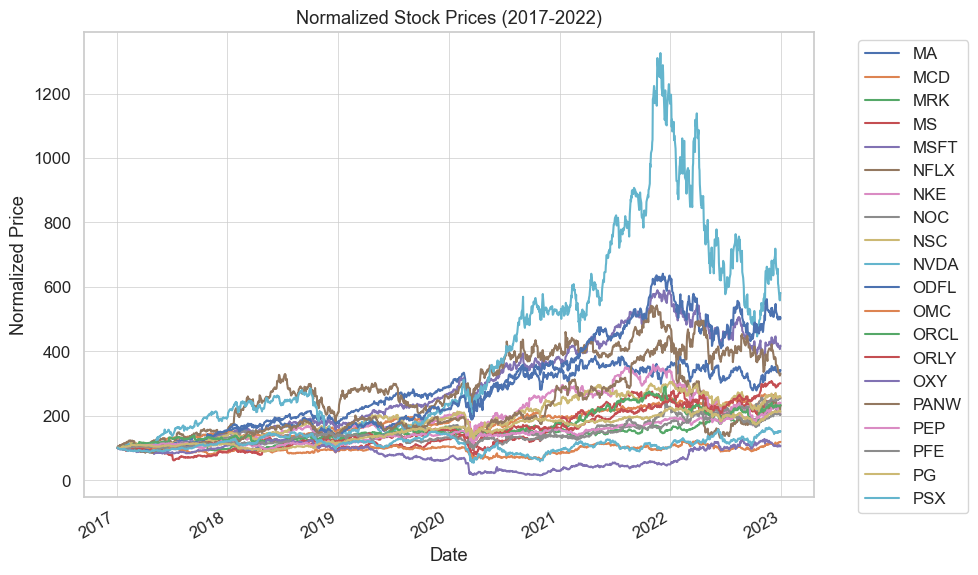

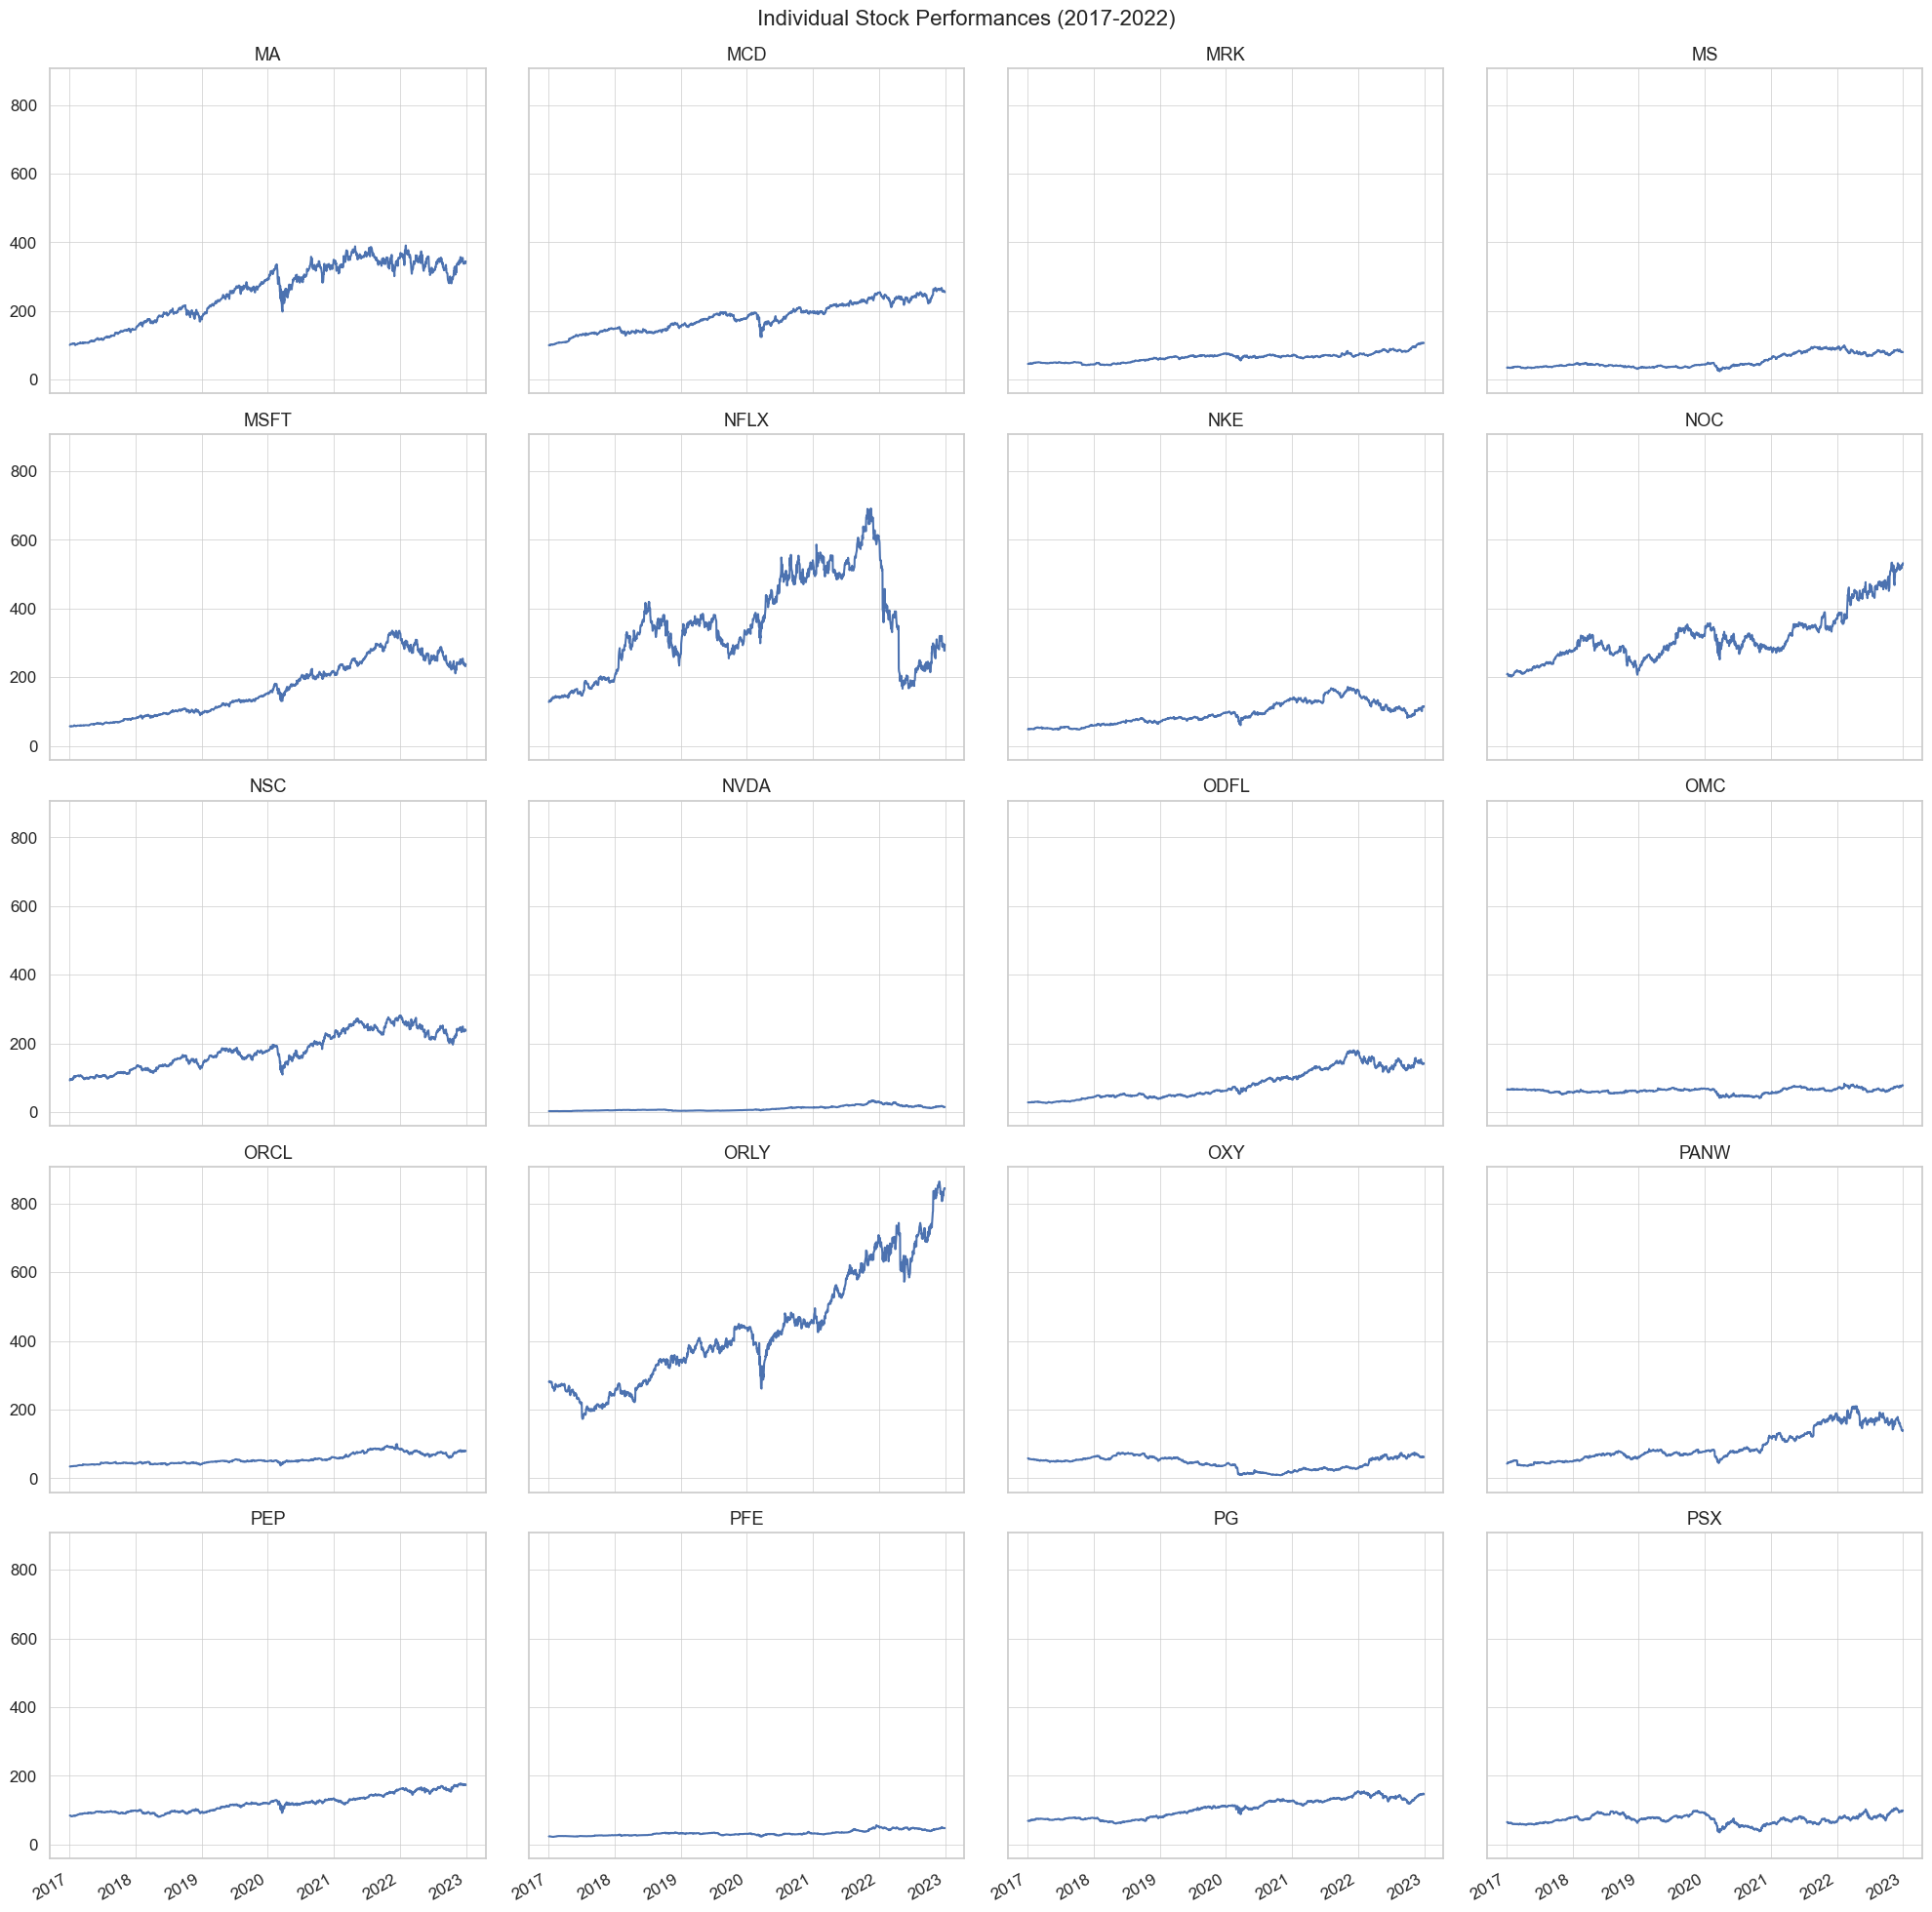

C:\Users\ghina\AppData\Local\Temp\ipykernel_14612\3615818977.py:28: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



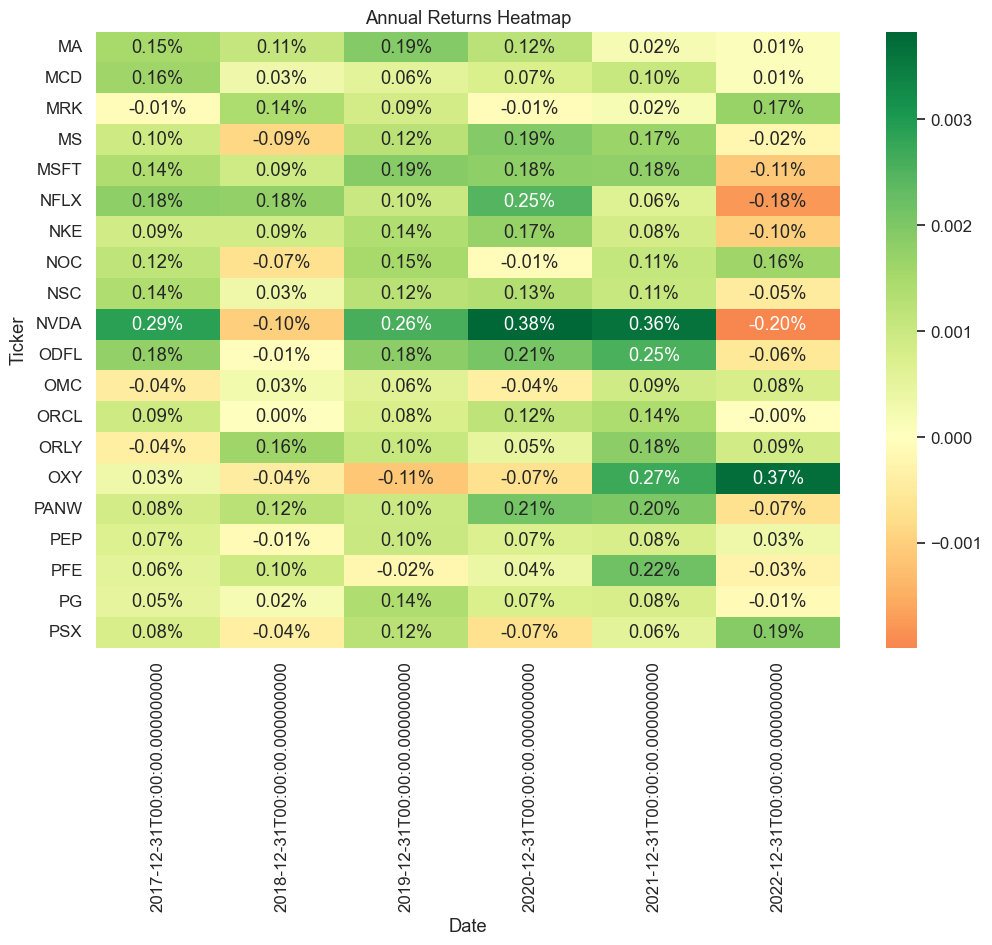

In [31]:

# 1. Normalized Price Plot
normalized_df = adj_close_df / adj_close_df.iloc[0] * 100
plt.figure(figsize=(12, 6))
normalized_df.plot(title="Normalized Stock Prices (2017-2022)")
plt.ylabel("Normalized Price")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Small Multiples
fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle("Individual Stock Performances (2017-2022)", fontsize=16)

for i, (asset, data) in enumerate(adj_close_df.items()):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    data.plot(ax=ax, title=asset)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# 3. Heatmap
returns_df = adj_close_df.pct_change()
annual_returns = returns_df.resample('Y').mean()

plt.figure(figsize=(12, 8))
sns.heatmap(annual_returns.T, annot=True, cmap='RdYlGn', center=0, fmt='.2%')
plt.title("Annual Returns Heatmap")
plt.show()


#Explain the thought process behind starting with the first graph and then adding different plots.

# 2. Applying EDA before building the model

## 2.1. Understanding the correlation between the stocks

In [32]:
# Calculate the correlation matrix
correlation_matrix = adj_close_df.corr()

# Calculate the correlation matrix
correlation_matrix = adj_close_df.corr()

# Create the mask to display only the lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
correlation_matrix = correlation_matrix.mask(mask)

# Create the interactive heatmap
fig = px.imshow(
    correlation_matrix,
    labels=dict(x="Stocks", y="Stocks", color="Correlation"),
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    color_continuous_scale='Plasma',  # Change the color scale to Plasma
    aspect='auto',
    zmin=-1, zmax=1,
)

# Add hover information
fig.update_traces(
    hovertemplate="<b>%{x}</b> vs <b>%{y}</b><br>Correlation: %{z}<extra></extra>",
    xgap=1, ygap=1  # Add gap to show white grid lines
)

# Update layout
fig.update_layout(
    title="Interactive Correlation Matrix of Adjusted Close Prices",
    xaxis_title="Stocks",
    yaxis_title="Stocks",
    yaxis=dict(scaleanchor="x", scaleratio=1),
    plot_bgcolor='white'  # Set background color to white for better grid visibility
)

# Show the plot
fig.show()


print("\nMost Correlated Assets:", correlation_matrix.unstack().sort_values(ascending=False).index[1])
print("Least Correlated Assets:", correlation_matrix.unstack().sort_values().index[0])


Most Correlated Assets: ('ORLY', 'PEP')
Least Correlated Assets: ('NFLX', 'OXY')


#### Correlation Matrix Analysis
Many of the stocks in the portfolio have high correlations (whether positive or negative), which could be an indicator that the initial diversification strategy is not optimal. High positive correlations indicate that many stocks move together, reducing the benefits of diversification. High negative correlations can provide some diversification benefits but might also imply that certain stocks consistently move in opposite directions, which could introduce volatility.


## 2.2. Evaluating the performance of an equally weighted portfolio

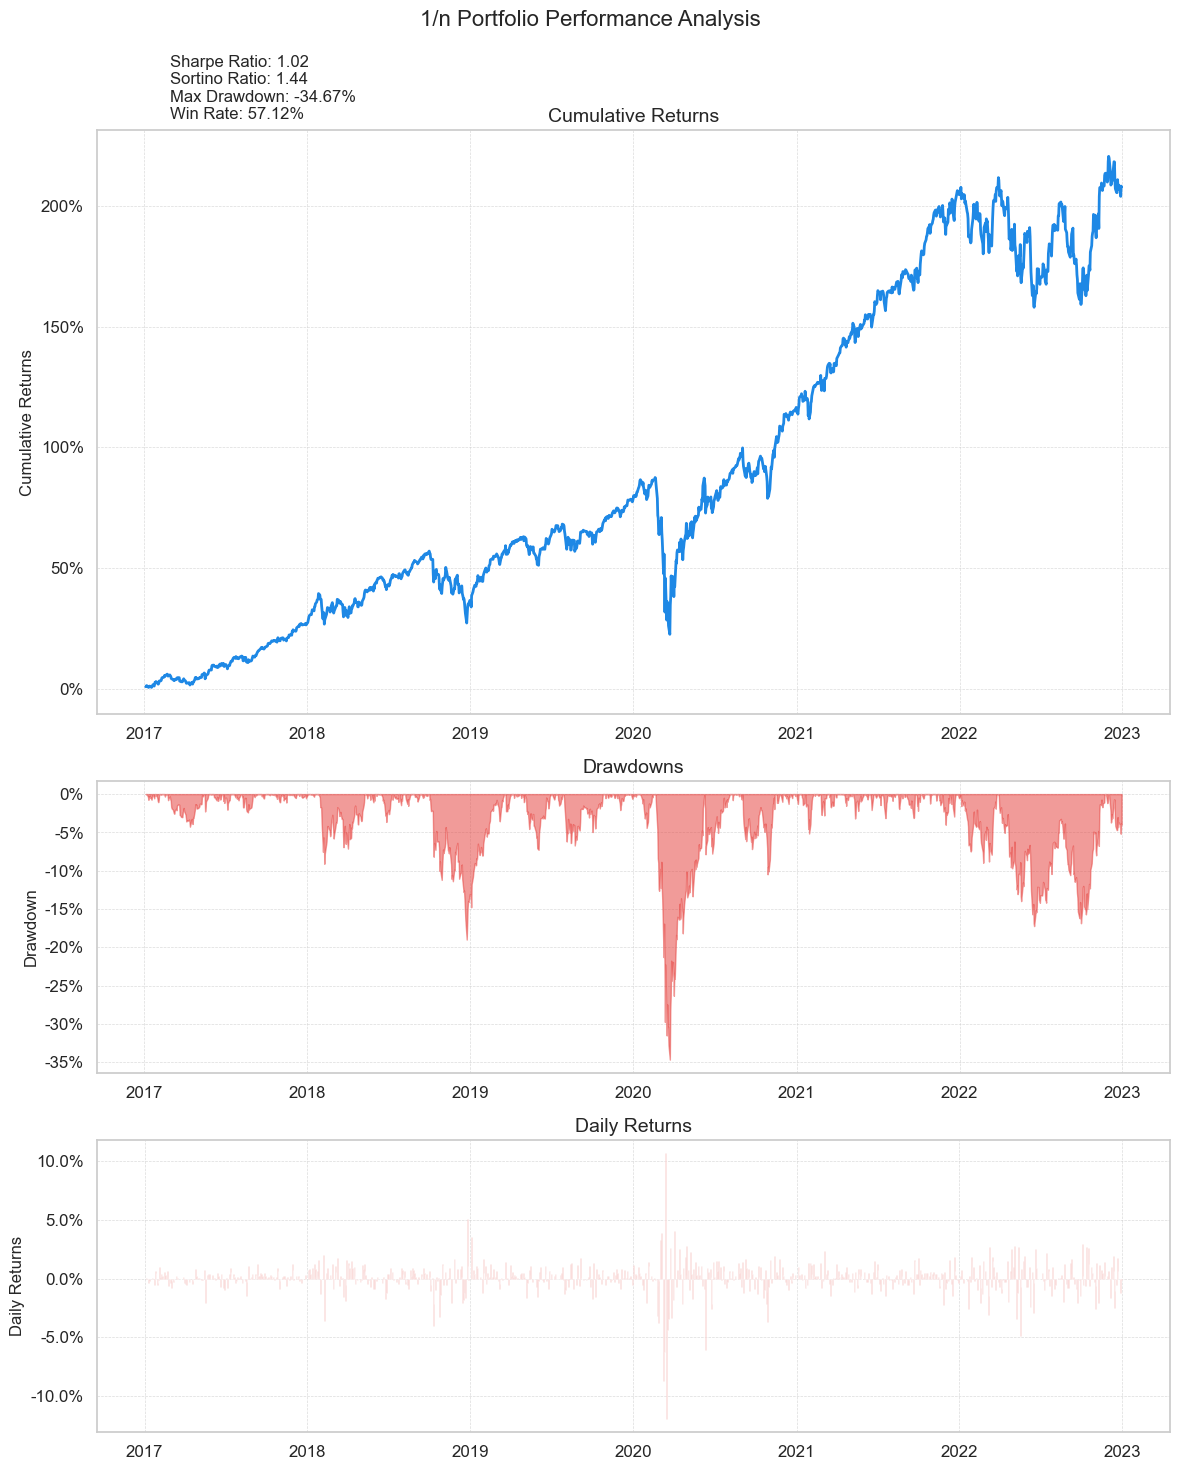


Portfolio Metrics:
Sharpe Ratio: 1.02
Sortino Ratio: 1.44
Max Drawdown: -34.67%
Win Rate: 57.12%


In [53]:
adj_close_df = prices_df["Adj Close"]

# Calculate returns and portfolio performance
returns = adj_close_df.pct_change().dropna()
n_assets = len(ASSETS)
portfolio_weights = n_assets * [1 / n_assets]
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), index=returns.index)

# Calculate metrics
cumulative_returns = (1 + portfolio_returns).cumprod()
drawdowns = qs.stats.to_drawdown_series(portfolio_returns)
sharpe_ratio = qs.stats.sharpe(portfolio_returns)
sortino_ratio = qs.stats.sortino(portfolio_returns)
max_drawdown = qs.stats.max_drawdown(portfolio_returns)
win_rate = qs.stats.win_rate(portfolio_returns)

# Create custom plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), gridspec_kw={'height_ratios': [2, 1, 1]})
fig.suptitle("1/n Portfolio Performance Analysis", fontsize=16)

# Cumulative Returns
ax1.plot(cumulative_returns.index, cumulative_returns.values, color='#1e88e5', linewidth=2)
ax1.set_ylabel("Cumulative Returns", fontsize=12)
ax1.set_title("Cumulative Returns", fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y-1)))

# Drawdowns
ax2.fill_between(drawdowns.index, drawdowns.values, 0, color='#e53935', alpha=0.5)
ax2.set_ylabel("Drawdown", fontsize=12)
ax2.set_title("Drawdowns", fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Daily Returns
ax3.bar(portfolio_returns.index, portfolio_returns.values, color='#e53935', alpha=0.5, width=1)
ax3.set_ylabel("Daily Returns", fontsize=12)
ax3.set_title("Daily Returns", fontsize=14)
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Format x-axis to show years
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Add metrics text box
metrics_text = (f"Sharpe Ratio: {sharpe_ratio:.2f}\n"
                f"Sortino Ratio: {sortino_ratio:.2f}\n"
                f"Max Drawdown: {max_drawdown:.2%}\n"
                f"Win Rate: {win_rate:.2%}")
fig.text(0.15, 0.95, metrics_text, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=1))

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust for main title
plt.show()

# Print metrics
print("\nPortfolio Metrics:")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Win Rate: {win_rate:.2%}")

## Analysis:

- Overall, cumulative returns are increasing over time.
- Between 2020 and 2021, the underwater plot shows a steep decrease in returns. The returns reached -34.67%. Looking at it from a short term investment period, selling during that time would have been an ideal approach for use if we were not risk takers.
- Between 2022 and 2023, the drawdown plot (underwater plot) shows a long period of negative returns.
- The Sharpe ratio is a measure of risk-adjusted return. Our sharpe ratio of 1.02 --> For every unit of risk, the excess return is 1.02. The sharpe ratio is acceptable yet not the best. It is indicative of a balance between risk and reward (return).
- The Sortino ratio is a measure of risk-adjusted return that differentiates between harmful volatility (downside risk) and total volatility used in the Sharpe ratio. In other words, we are looking at how well our investment did relative to downside risk. In our case, for every unit of downside risk, the portfolio or investment is providing an excess return of 1.44 units.
- The win rate is the ratio of profitable trades to the total number of trades made, expressed as a percentage. A win rate of 57.12% means that out of all the trades or investments made, 57.12% resulted in a profit. Although this might be indicative of consistency in picking profitable trades, it does not mean that we are profitable. Yet, that is indicated in our cumulative returns plot.


## 2.3 Understanding the basic portfolio and exporting to html

In [34]:
qs.reports.metrics(portfolio_returns,
                   benchmark="SPY",
                   mode="basic")

[*********************100%%**********************]  1 of 1 completed
c:\Users\ghina\anaconda3\Lib\site-packages\quantstats\stats.py:510: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



                    Benchmark (SPY)    Strategy
------------------  -----------------  ----------
Start Period        2017-01-04         2017-01-04
End Period          2022-12-30         2022-12-30
Risk-Free Rate      0.0%               0.0%
Time in Market      100.0%             100.0%

Cumulative Return   68.78%             205.6%
CAGR﹪              6.22%              13.74%

Sharpe              0.54               1.01
Prob. Sharpe Ratio  90.37%             99.24%
Sortino             0.74               1.43
Sortino/√2          0.52               1.01
Omega               1.22               1.22

Max Drawdown        -34.1%             -34.67%
Longest DD Days     361                237

Gain/Pain Ratio     0.11               0.22
Gain/Pain (1M)      0.59               1.37

Payoff Ratio        0.86               0.92
Profit Factor       1.11               1.22
Common Sense Ratio  0.94               1.12
CPC Index           0.52               0.64
Tail Ratio          0.85               0

### Analysis:

The portfolio:
- Significantly outperforms the benchmark (SPY) with a cumulative return of 205.6% compared to 68.78% & a CAGR of 13.74% versus 6.22%.
- Achieves a higher Sharpe ratio (1.01 vs. 0.54) and Sortino ratio (1.43 vs. 0.74), indicating better risk-adjusted returns and downside risk management.
- Maximum drawdown is slightly higher(-34.67% vs. -34.1%), but the portfolio recovers faster from drawdowns and maintains positive performance during market downturns, demonstrating robust and resilient investment performance over the analyzed period.


### Generating HTML

In [35]:
'''qs.reports.html(portfolio_returns,
                benchmark="SPY",
                title="1/n portfolio",
                download_filename="Portfolio evaluation M,N,O,L,P.html")'''

'qs.reports.html(portfolio_returns,\n                benchmark="SPY",\n                title="1/n portfolio",\n                download_filename="Portfolio evaluation M,N,O,L,P.html")'

# 3. Monte carlo Simulations

## 3.1. Retrieving the data

In [57]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
ASSETS = ["MSFT", "MCD", "MA", "MRK", "MS","NFLX", "NVDA","NKE","NOC","NSC","ORCL","OXY","OMC","ORLY","ODFL","PG","PEP","PFE","PSX","PANW" ]
ASSETS.sort()
n_assets = len(ASSETS)

In [37]:
prices_df = yf.download(ASSETS,
                        start="2017-01-01",
                        end="2022-12-31")

[*********************100%%**********************]  20 of 20 completed


In [38]:
returns_df = prices_df["Adj Close"].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

## 3.2. Prepping the data for the Simulation

In [55]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [56]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    vol = np.sqrt(
        np.dot(weights[i].T, np.dot(cov_mat, weights[i]))
    )
    portf_vol.append(vol)
portf_vol = np.array(portf_vol)  

portf_sharpe_ratio = portf_rtns / portf_vol

portf_results_df = pd.DataFrame(
    {"returns": portf_rtns,
     "volatility": portf_vol,
     "sharpe_ratio": portf_sharpe_ratio}
)
portf_results_df

,returns,volatility,sharpe_ratio
0,0.193626,0.196873,0.983506
1,0.215191,0.215380,0.999124
2,0.213225,0.216331,0.985646
3,0.233010,0.212471,1.096669
4,0.205404,0.209310,0.981340
...,...,...,...
99995,0.212009,0.221851,0.955637
99996,0.205336,0.207026,0.991837
99997,0.219779,0.214559,1.024328
99998,0.215754,0.209081,1.031917


## 3.3 Visualizing the Efficient Frontier without the stocks

C:\Users\ghina\AppData\Local\Temp\ipykernel_14612\1732641209.py:43: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



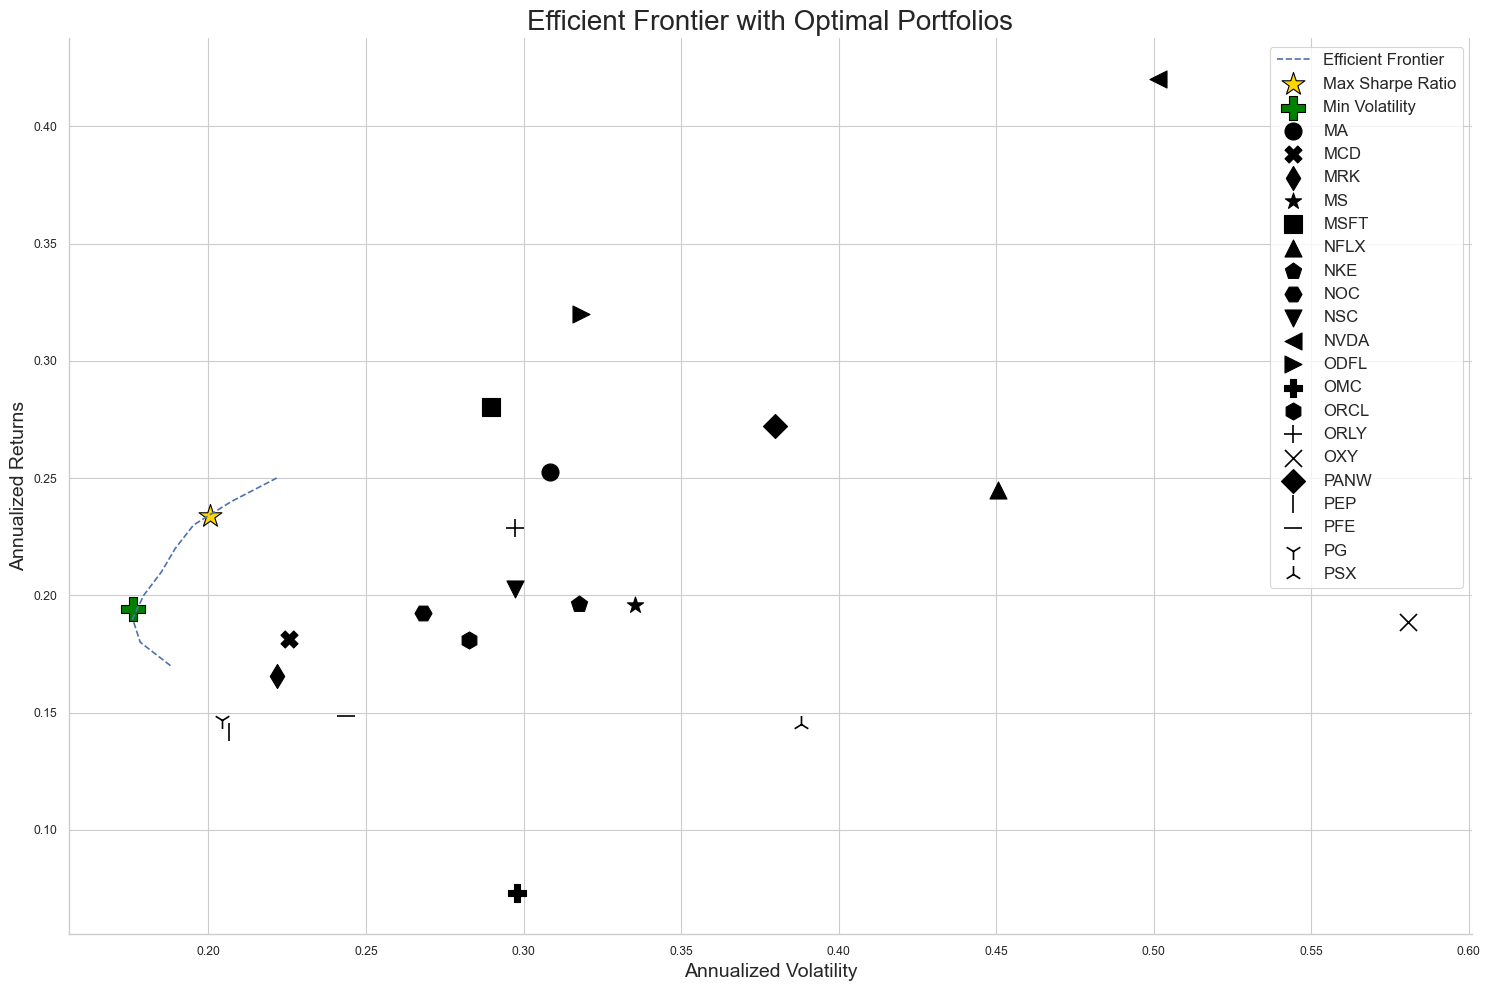

In [41]:
N_POINTS = 100000

ef_rtn_list = []
ef_vol_list = []

possible_ef_rtns = np.linspace(
    portf_results_df["returns"].min(), 
    portf_results_df["returns"].max(), 
    N_POINTS
)
possible_ef_rtns = np.round(possible_ef_rtns, 2)    
portf_rtns = np.round(portf_rtns, 2)

for rtn in possible_ef_rtns:
    if rtn in portf_rtns:
        ef_rtn_list.append(rtn)
        matched_ind = np.where(portf_rtns == rtn)
        ef_vol_list.append(np.min(portf_vol[matched_ind]))

# Find max Sharpe ratio and min volatility portfolios
max_sharpe_portfolio = portf_results_df.loc[portf_results_df['sharpe_ratio'].idxmax()]
min_vol_portfolio = portf_results_df.loc[portf_results_df['volatility'].idxmin()]

MARKERS = ["o", "X", "d", "*", 's', '^', 'p', 'H', 'v', '<', '>', 'P', 'h', '+', 'x', 'D', '|', '_', '1', '2']

with sns.plotting_context("paper"):
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot efficient frontier
    ax.plot(ef_vol_list, ef_rtn_list, "b--", label="Efficient Frontier")
    
    # Mark maximum Sharpe ratio portfolio
    ax.scatter(max_sharpe_portfolio["volatility"], max_sharpe_portfolio["returns"],
               s=300, color="gold", edgecolors="black", marker="*", label="Max Sharpe Ratio")
    
    # Mark minimum volatility portfolio
    ax.scatter(min_vol_portfolio["volatility"], min_vol_portfolio["returns"],
               s=300, color="green", edgecolors="black", marker="P", label="Min Volatility")

    # Plot individual assets
    for asset_index in range(n_assets):
        ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                   y=avg_returns[asset_index], 
                   marker=MARKERS[asset_index], 
                   s=150, color="black",
                   label=ASSETS[asset_index])
    
    # Add titles and labels
    ax.set_title("Efficient Frontier with Optimal Portfolios", fontsize=20)
    ax.set_xlabel("Annualized Volatility", fontsize=14)
    ax.set_ylabel("Annualized Returns", fontsize=14)
    ax.legend(loc="best", fontsize=12)

    sns.despine()
    plt.tight_layout()
    plt.show()


- Neftflix appears as a triangle at the top-right, indicating high expected returns but also high volatility.

- Microsoft appears to offer attractive returns without extreme risk.

- Nvidia appears to have the highest returns but has the highest volatility


In [42]:
max_sharpe_ind = np.argmax(portf_results_df["sharpe_ratio"])
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df["volatility"])
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [43]:
print_portfolio_summary(max_sharpe_portf,
                        weights[max_sharpe_ind],
                        ASSETS,
                        name="Maximum Sharpe Ratio")

#Add visualization to view the portfolio weights

Maximum Sharpe Ratio portfolio ----
Performance
returns: 23.39% volatility: 20.04% sharpe_ratio: 116.71% 
Weights
MA: 8.48% MCD: 3.57% MRK: 10.03% MS: 1.22% MSFT: 4.50% NFLX: 4.43% NKE: 1.16% NOC: 9.47% NSC: 0.38% NVDA: 11.17% ODFL: 10.87% OMC: 1.02% ORCL: 1.50% ORLY: 3.30% OXY: 0.30% PANW: 5.74% PEP: 6.62% PFE: 6.26% PG: 9.97% PSX: 0.01% 

In [44]:
print_portfolio_summary(min_vol_portf,
                        weights[min_vol_ind],
                        ASSETS,
                        name="Minimum Volatility")

#Add visualization to view the portfolio weights

Minimum Volatility portfolio ----
Performance
returns: 19.41% volatility: 17.59% sharpe_ratio: 110.32% 
Weights
MA: 1.87% MCD: 8.02% MRK: 9.59% MS: 3.03% MSFT: 3.88% NFLX: 1.65% NKE: 2.65% NOC: 1.04% NSC: 2.10% NVDA: 0.15% ODFL: 9.25% OMC: 2.41% ORCL: 1.22% ORLY: 4.49% OXY: 1.12% PANW: 8.55% PEP: 12.24% PFE: 10.99% PG: 13.81% PSX: 1.95% 

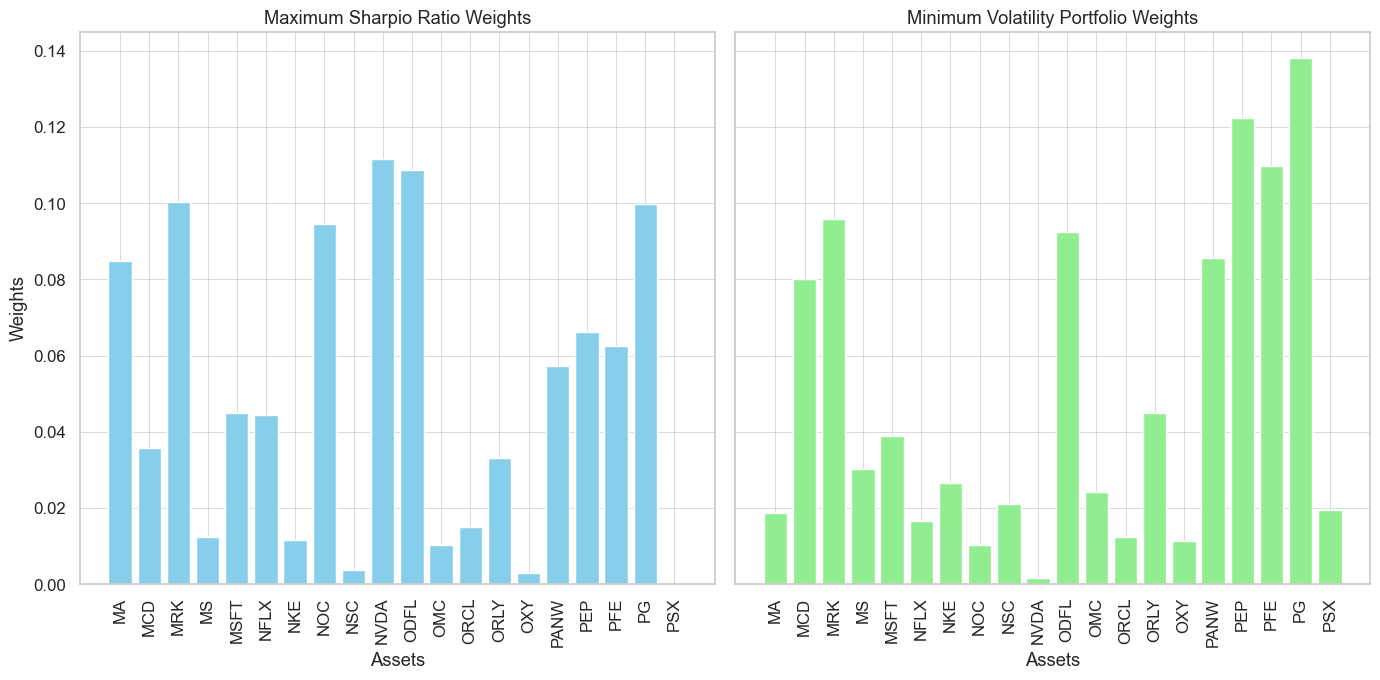

In [58]:
# Find indices of max Sharpe ratio and min volatility portfolios
max_sharpe_ind = np.argmax(portf_results_df["sharpe_ratio"])
min_vol_ind = np.argmin(portf_results_df["volatility"])

# Get the weights of the max Sharpe ratio and min volatility portfolios
max_sharpe_weights = weights[max_sharpe_ind]
min_vol_weights = weights[min_vol_ind]

# Sort assets and weights in ascending order of asset names
sorted_indices = np.argsort(ASSETS)
sorted_assets = np.array(ASSETS)[sorted_indices]
sorted_max_sharpe_weights = max_sharpe_weights[sorted_indices]
sorted_min_vol_weights = min_vol_weights[sorted_indices]

# Plot side-by-side bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharey=True)

# Max Sharpe Ratio Portfolio Weights
axes[0].bar(sorted_assets, sorted_max_sharpe_weights, color='skyblue')
axes[0].set_title('Maximum Sharpio Ratio Weights')
axes[0].set_xlabel('Assets')
axes[0].set_ylabel('Weights')
axes[0].tick_params(axis='x', rotation=90)

# Min Volatility Portfolio Weights
axes[1].bar(sorted_assets, sorted_min_vol_weights, color='lightgreen')
axes[1].set_title('Minimum Volatility Portfolio Weights')
axes[1].set_xlabel('Assets')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# 4. Leverage

In [46]:
max_leverage = cp.Parameter()
weights = cp.Variable(n_assets)
avg_returns = avg_returns.values

gamma_par = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(
    portf_rtn_cvx - gamma_par * portf_vol_cvx
)
prob_with_leverage = cp.Problem(objective_function,
                                [cp.sum(weights) == 1,
                                cp.norm(weights, 1) <= max_leverage])

In [47]:
N_POINTS = 25
portf_rtn_cvx_ef = []
portf_vol_cvx_ef = []
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for gamma in gamma_range:
    gamma_par.value = gamma
    portf_vol_cvx_ef.append(cp.sqrt(portf_vol_cvx).value)
    portf_rtn_cvx_ef.append(portf_rtn_cvx.value)
    weights_ef.append(weights.value)

In [48]:
LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25

portf_vol_l = np.zeros((N_POINTS, len_leverage))
portf_rtn_l = np.zeros(( N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))

for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
    for gamma_ind in range(N_POINTS):
        max_leverage.value = leverage
        gamma_par.value = gamma_range[gamma_ind]
        prob_with_leverage.solve()
        portf_vol_l[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value


c:\Users\ghina\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.



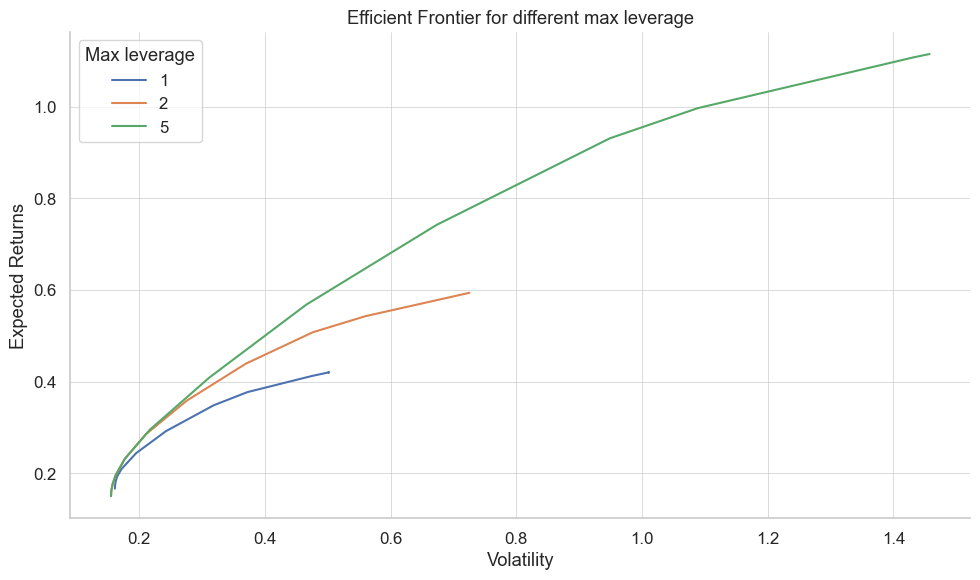

In [49]:
fig, ax = plt.subplots()

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l[:, leverage_index],
             portf_rtn_l[:, leverage_index],
             label=f"{leverage}")

ax.set(title="Efficient Frontier for different max leverage",
       xlabel="Volatility",
       ylabel="Expected Returns")
ax.legend(title="Max leverage")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_16", dpi=200)

# Analysis of Efficient Frontier with Leverage

The chart illustrates the efficient frontier for portfolios with different maximum leverage constraints (1x, 2x, and 5x). The efficient frontier represents the set of optimal portfolios that offer the highest expected return for a defined level of risk (volatility).

## Key Observations

### Leverage Impact on Expected Returns:

- **1x Leverage (Blue)**: This represents portfolios without additional leverage. The expected returns increase with volatility but at a more conservative rate.
- **2x Leverage (Orange)**: This shows the effect of doubling the leverage. The curve shifts upwards, indicating higher expected returns but also higher risk compared to 1x leverage.
- **5x Leverage (Green)**: With quintuple leverage, the curve shifts even further upwards. The expected returns significantly increase for higher levels of volatility.

### Risk-Return Trade-Off:

- Higher leverage allows for higher expected returns, but it also comes with increased volatility. The steepness of the curves illustrates this trade-off. As leverage increases, the risk (volatility) associated with achieving higher returns also increases.

### Optimal Portfolio Selection:

- For investors willing to take on more risk, the 5x leverage frontier offers the highest potential returns. However, this comes with much greater volatility, which might not be suitable for all investors.
- The 2x leverage frontier provides a middle ground, offering better returns than the 1x leverage frontier with manageable additional risk.
- The 1x leverage frontier represents the most conservative approach, suitable for risk-averse investors.

## Strategic Implications

### Risk Management:

- Investors need to assess their risk tolerance when choosing the appropriate leverage level. Higher leverage can amplify returns but also increases exposure to market volatility and potential losses.

### Portfolio Diversification:

- Even with increased leverage, diversification remains critical to managing risk. The efficient frontier assumes an optimal mix of assets, and poor diversification can negate the benefits of leverage.

### Investment Goals:

- The choice of leverage should align with the investor's financial goals, time horizon, and risk appetite. Long-term investors might prefer higher leverage for growth, while short-term investors might opt for lower leverage to preserve capital.
